In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gp
from geopandas import GeoDataFrame
from shapely.geometry import LineString
from shapely.geometry import MultiPoint
from shapely.geometry import Point
from shapely.geometry import shape
import shapely
import networkx as nx
import os.path
from os import path
import pathlib
import pandas as pd
from datetime import datetime
import numpy as np
from tqdm.notebook import tqdm



import geopy.distance
import geojson


from OSMPythonTools.api import Api as osm_api
ox.config(log_console=True, use_cache=True)

In [2]:
G = ox.graph.graph_from_place('Berlin, Germany', retain_all=True, buffer_dist=2500, network_type='drive', simplify=False)
##G = ox.graph.graph_from_place()

In [28]:
length_30 = 0
length_50 = 0
length_total = 0

for u, v, k, data in G.edges(data=True, keys=True):
    if('maxspeed' in data.keys() and 'length' in data.keys()):
        length_total += float(data['length'])
        
        speed = data['maxspeed']

        if (speed == 'DE:urban'):
            speed = 50.0
        elif (speed == 'walk'):
            speed = 6.0
        elif (speed == 'none'):
            speed = 130.0

        speed = float(speed)
        
        if(speed == 30):
            length_30 += float(data['length'])
        if(speed == 50):
            length_50 += float(data['length'])
        #print(data['maxspeed:conditional'])
        #if(type(data['maxspeed']) == list):
        #try:
        #if('[' in data['maxspeed']):
        #except:
            
    #data['maxspeed'] = ""
        
            #print(data['maxspeed'])

print("{:3.2f}% der Straßen sind Tempo 30 Zone".format(100*length_30 / length_total))
print("{:3.2f}% der Straßen sind Tempo 50 Zone".format(100*length_50 / length_total))

67.99% der Straßen sind Tempo 30 Zone
25.35% der Straßen sind Tempo 50 Zone


In [ ]:
nodes, edges = ox.graph_to_gdfs(G)

In [37]:
subset = edges[edges['maxspeed'] == '30']
subset = subset.append(edges[edges['maxspeed'] == '50'])
subset = subset[['geometry','maxspeed']]
subset
#edges
#or edges['maxspeed'] == 50]

,geometry,maxspeed
20,"LINESTRING (13.33956 52.56408, 13.33944 52.56385)",30
45,"LINESTRING (13.35897 52.57325, 13.35906 52.57323)",30
47,"LINESTRING (13.35943 52.57297, 13.35950 52.57286)",30
48,"LINESTRING (13.36081 52.57033, 13.36086 52.57023)",30
99,"LINESTRING (13.29537 52.53962, 13.29552 52.53961)",30
...,...,...
390174,"LINESTRING (13.43068 52.48148, 13.43112 52.48153)",50
390175,"LINESTRING (13.43235 52.48167, 13.43288 52.48173)",50
390176,"LINESTRING (13.43235 52.48167, 13.43208 52.48164)",50
390186,"LINESTRING (13.43498 52.49098, 13.43459 52.49058)",50


In [38]:
geo_df = GeoDataFrame(subset['maxspeed'], geometry=subset['geometry'])
geo_df.to_file("../results/allowed_car_speed.geojson", driver='GeoJSON')

In [ ]:
worked_for_id = []

for i,feature in tqdm(enumerate(features)):
    if 'relative_real_speed' in feature['properties'].keys():
        worked_for_id.append(i)
        print("skipped {}".format(i))
        continue
    
    plz_graph = ox.graph_from_polygon(shape(feature['geometry']),retain_all=True, network_type='drive', simplify=False)
  
    
    try:
        for u, v, k, data in plz_graph.edges(data=True, keys=True):
            if('maxspeed' not in data.keys()):
                data['maxspeed'] = 50

            real_speed_value = speed_df[speed_df['osm_way_id'] == data['osmid']]['speed_kph_mean'].mean()
            if(real_speed_value == real_speed_value):

                speed = data['maxspeed']

                if (speed == 'DE:urban'):
                    speed = 50.0
                elif (speed == 'walk'):
                    speed = 6.0
                elif (speed == 'none'):
                    speed = 130.0

                speed = float(speed)


                data['real_speed'] = real_speed_value
                data['rel_real_speed'] = real_speed_value/speed
  

        nodes, edges = ox.graph_to_gdfs(plz_graph)
    except:
        continue
        
    try:
        plz_speed_df = edges[['real_speed','rel_real_speed','length']].dropna()
        plz_speed_weighted_avg = (plz_speed_df['length']*plz_speed_df['rel_real_speed']/plz_speed_df['length'].sum()).sum()
        plz_abs_weighted_avg = (plz_speed_df['length']*plz_speed_df['real_speed']/plz_speed_df['length'].sum()).sum()

    except:
        plz_speed_df = []
        plz_speed_weighted_avg = -1
        plz_abs_weighted_avg = -1


    feature['properties']['relative_real_speed'] = plz_speed_weighted_avg
    feature['properties']['absolute_real_speed'] = plz_abs_weighted_avg
    feature['properties']['relative_real_speed_data_points'] = len(plz_speed_df)

    print("{} ø rel_speed: {}, {} data points".format(feature['properties']['plz'], plz_speed_weighted_avg, len(plz_speed_df)))

    worked_for_id.append(i)

    #print(feature)

In [ ]:
features

In [18]:
[id for id in range(198) if id not in worked_for_id]

[190, 193]

In [23]:

#with open('myfile.geojson', 'w') as f:
#   dump(feature_collection, f)

with open('../results/plz-traffic.geojson', 'w') as f:
    gj2 = gj
    gj2['features'] = features
    geojson.dump(gj2,f)

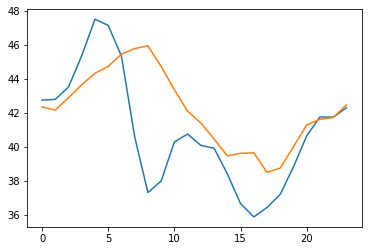

In [7]:
speed_df = speed_df.sort_values('utc_timestamp')
speed_df = speed_df.groupby(['utc_timestamp','osm_way_id']).mean().reset_index()

speed_df['weekday'] = [datetime.strptime(time, '%Y-%m-%dT%H:%M:%S.000Z').weekday() for time in speed_df['utc_timestamp']]

#plt.xkcd()
plt.plot(speed_df[speed_df['weekday'] <= 4].groupby(['hour']).mean()['speed_kph_mean'])
#plt.show()

plt.plot(speed_df[speed_df['weekday'] > 4].groupby(['hour']).mean()['speed_kph_mean'])
plt.show()

In [6]:
nodes, edges = ox.graph_to_gdfs(G)

0

51

<AxesSubplot:>

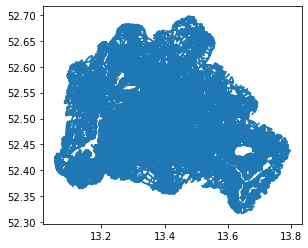

In [7]:
combined_df = speed_df.groupby(['osm_way_id']).mean().reset_index()[['osm_way_id','speed_kph_mean']]
combined_df = combined_df.merge(edges,left_on='osm_way_id',right_on='osmid')
#edges

geo_df = GeoDataFrame(combined_df['speed_kph_mean'], geometry=combined_df['geometry'])
geo_df.to_file("../results/uber_mean_speed.geojson", driver='GeoJSON')

SyntaxError: invalid syntax (<ipython-input-160-ac14e157f2fb>, line 20)

In [9]:
G.edges[172594,223826118,0]


{'osmid': 40817197,
 'name': 'Emmentaler Straße',
 'highway': 'secondary',
 'maxspeed': '50',
 'oneway': False,
 'length': 11.758}

[api] downloading data: way/4045243


{'cycleway:right': 'track', 'highway': 'primary', 'lanes': '3', 'lit': 'yes', 'maxspeed': '50', 'name': 'Frankfurter Allee', 'name:etymology:wikidata': 'Q4024', 'oneway': 'yes', 'postal_code': '10247', 'ref': 'B 1;B 5', 'sidewalk': 'right', 'surface': 'asphalt'}


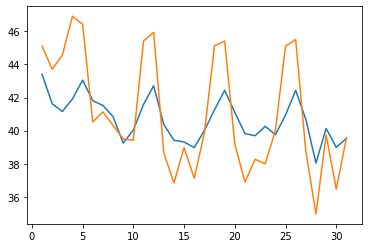

,day,osm_way_id,year,month,hour,osm_start_node_id,osm_end_node_id,speed_kph_mean,speed_kph_stddev,weekday
0,1.0,2.027964e+08,2020.0,1.0,9.272633,1.290863e+09,1.242970e+09,43.414763,9.978526,1.957938
1,2.0,2.071910e+08,2020.0,1.0,12.230257,1.327179e+09,1.276472e+09,41.621730,9.627900,2.956525
2,3.0,2.054962e+08,2020.0,1.0,12.960806,1.308668e+09,1.258446e+09,41.154582,9.452216,3.955228
3,4.0,2.054736e+08,2020.0,1.0,12.322157,1.313258e+09,1.262417e+09,41.916699,9.411480,4.944736
4,5.0,2.074645e+08,2020.0,1.0,11.179938,1.319002e+09,1.271199e+09,43.052003,9.339642,5.935699
5,6.0,2.040999e+08,2020.0,1.0,13.209088,1.288773e+09,1.234764e+09,41.812503,9.647439,0.236695
6,7.0,2.028472e+08,2020.0,1.0,13.861266,1.271485e+09,1.222625e+09,41.520497,9.479776,0.962016
7,8.0,2.034988e+08,2020.0,1.0,13.702818,1.279946e+09,1.225594e+09,40.842867,9.437746,1.963353
8,9.0,2.037653e+08,2020.0,1.0,13.820653,1.281079e+09,1.229174e+09,39.245092,9.653691,2.959394
9,10.0,2.020738e+08,2020.0,1.0,13.864194,1.273567e+09,1.223514e+09,40.035589,9.570595,3.957907


In [301]:
way_id = 28496022
way_id = 4045243

api = osm_api()
way = api.query('way/{}'.format(way_id))

print(way.tags())

#speed_df.sort_values('utc_timestamp')

day_avg = speed_df.groupby(['day']).mean().reset_index()
morning_avg = speed_df[speed_df['hour'].isin(range(6,9))].groupby(['day']).mean().reset_index()

#avg_speed = day_avg['speed_kph_mean']
#avg_speed = speed_df['speed_kph_mean']
#timestamp = speed_df['utc_timestamp']

plt.plot(day_avg['day'], day_avg['speed_kph_mean'])
plt.plot(morning_avg['day'], morning_avg['speed_kph_mean'])
plt.show()

day_avg

In [74]:
way_id = 385627960
node_id = 223826118


api = osm_api()
way = api.query('node/{}'.format(node_id))
lat = way.lat()
lon = way.lon()

print(lat)
print(lon)

#nominatim = Nominatim()
#areaId = nominatim.query('Berlin, Germany').areaId()

#overpass = Overpass()
#query = overpassQueryBuilder(areaId, elementType='way', id=str(way_id), includeGeometry=True)
#way = overpass.query(query)

#way.elements()

52.5703921
13.3609579


In [8]:
G = ox.graph_from_place('Berlin, DE', network_type="drive")

In [61]:
osm_id_df = speed_df[['osm_way_id','osm_start_node_id','osm_end_node_id','speed_kph_mean']]
osm_id_df = osm_id_df.groupby(['osm_start_node_id','osm_end_node_id']).mean().reset_index()
in_graph = [ id_start in G.nodes and id_end in G.nodes and id_end in G[id_start].keys() for id_start, id_end in zip(osm_id_df['osm_start_node_id'], osm_id_df['osm_end_node_id'])]

osm_id_df = osm_id_df[in_graph]

#osm_id_df = osm_id_df[:100]

osm_id_df['osm_segment'] = [G.edges[id_start,id_end,0] for id_start,id_end in zip(osm_id_df['osm_start_node_id'], osm_id_df['osm_end_node_id'])]

has_geometry = ['geometry' in way.keys() for way in osm_id_df['osm_segment']]
has_maxspeed = ['maxspeed' in way.keys() for way in osm_id_df['osm_segment']]
osm_id_df['maxspeed'] = [segment['maxspeed'] if has_maxspeed[i] else 0 for i,(segment,start,end) in enumerate(zip(osm_id_df['osm_segment'],osm_id_df['osm_start_node_id'],osm_id_df['osm_end_node_id']))]
osm_id_df['speed_percent'] = osm_id_df['speed_kph_mean'] / [float(speed) if type(speed) in [str,int] else float(max(speed)) for speed in osm_id_df['maxspeed']]


#osm_id_df = osm_id_df[has_geometry]
osm_id_df['street'] = [ segment['name'] if 'name' in segment.keys() else str(segment.keys())  for segment in osm_id_df['osm_segment']]

osm_id_df
#osm_id_df[['osm_segment','speed_percent','maxspeed']]


,osm_start_node_id,osm_end_node_id,osm_way_id,speed_kph_mean,osm_segment,maxspeed,speed_percent,street
4,172546,530313,24295532,42.823000,"{'osmid': 24295532, 'name': 'Emmentaler Straße...",50,0.856460,Emmentaler Straße
5,172546,28345850,4638312,33.443000,"{'osmid': 4638312, 'oneway': True, 'name': 'Em...",50,0.668860,Emmentaler Straße
10,172562,530351,4804203,32.428692,"{'osmid': 4804203, 'oneway': True, 'lanes': '2...",50,0.648574,"dict_keys(['osmid', 'oneway', 'lanes', 'highwa..."
14,172564,21509247,27606741,37.198467,"{'osmid': 27606741, 'oneway': True, 'lanes': '...",50,0.743969,Kurt-Schumacher-Platz
17,172587,29493004,31910522,47.428179,"{'osmid': 31910522, 'oneway': True, 'lanes': '...",50,0.948564,Lindauer Allee
...,...,...,...,...,...,...,...,...
26387,6298976090,6298973779,172421115,40.474000,"{'osmid': 172421115, 'oneway': False, 'lanes':...",30,1.349133,Buckower Damm
26465,6366276983,29789747,385888165,37.521647,"{'osmid': 385888165, 'oneway': True, 'lanes': ...",50,0.750433,Urbanstraße
26485,6400342990,6400342991,559214567,33.168791,"{'osmid': 559214567, 'lanes': '3', 'name': 'Wi...",50,0.663376,Wilhelmstraße
26487,6400342991,6400342990,559214567,24.315226,"{'osmid': 559214567, 'lanes': '3', 'name': 'Wi...",50,0.486305,Wilhelmstraße


In [21]:
##geometry = [row['geometry'] if row[has_geometry] else 0 for i,row in enumerate(osm_id_df['osm_segment'])]
geometry = [segment['geometry'] if has_geometry[i] else LineString([(G.nodes[start]['x'],G.nodes[start]['y']),(G.nodes[end]['x'],G.nodes[end]['y'])]) for i,(segment,start,end) in enumerate(zip(osm_id_df['osm_segment'],osm_id_df['osm_start_node_id'],osm_id_df['osm_end_node_id']))]


#geometry
#max_speed

In [ ]:

#geometry

geo_df = GeoDataFrame(osm_id_df['speed_kph_mean'], geometry=geometry)
geo_df.to_file("../results/uber_mean_speed.geojson", driver='GeoJSON')

In [142]:
26904555 in G.nodes

True

In [43]:
G.nodes[172594]

{'y': 52.5703344, 'x': 13.3608121, 'osmid': 172594}

In [11]:
G[40817197]

KeyError: 40817197

In [9]:
G.edges[172594,223826118,0]

{'osmid': 40817197,
 'name': 'Emmentaler Straße',
 'highway': 'secondary',
 'maxspeed': '50',
 'oneway': False,
 'length': 11.758}

In [152]:
27587520 in G[26904555].keys()

True

In [ ]:
#zip the coordinates into a point object and convert to a GeoData Frame
geometry = [Point(xy) for xy in zip(df.X, df.Y)]
geo_df = GeoDataFrame(df, geometry=geometry)

# aggregate these points with the GrouBy
geo_df = geo_df.groupby(['track_seg_point_id', 'Hour'])['geometry'].apply(lambda x: LineString(x.tolist()))
geo_df = GeoDataFrame(geo_df, geometry='geometry')

In [54]:
 = G.datafr

AttributeError: 'MultiDiGraph' object has no attribute 'datafr'

In [145]:
#nodes, edges = ox.graph_to_gdfs(G)

#edges = edges.drop(columns=['access','service','tunnel','junction','width','est_width','area','oneway','lanes','bridge','ref','name','highway','u','v','key'])
##edges
##geo_edges = GeoDataFrame(edges, geometry='geometry')
edges['osmid'] = [id if type(id)==int else id[0] for id in edges['osmid']]
edges['maxspeed'] = [speed[0] if type(speed)==list else speed for speed in edges['maxspeed']]
edges['maxspeed'] = [50.0 if speed=="DE:urban" else speed for speed in edges['maxspeed']]
edges['maxspeed'] = [8.0 if speed=="walk" or speed=="5 mph" else float(speed) for speed in edges['maxspeed']]
edges.dropna().to_file("../results/berlin_max_speed.geojson", driver='GeoJSON')



In [146]:
edges.dropna().head(50)

,osmid,maxspeed,length,geometry
0,4610047,50.0,21.907,"LINESTRING (13.33550 52.56521, 13.33560 52.565..."
1,5117633,50.0,52.407,"LINESTRING (13.33550 52.56521, 13.33565 52.565..."
2,31740296,50.0,280.903,"LINESTRING (13.33550 52.56521, 13.33533 52.565..."
3,24973218,50.0,17.179,"LINESTRING (13.34661 52.56703, 13.34664 52.56688)"
4,40817055,50.0,12.127,"LINESTRING (13.34661 52.56703, 13.34643 52.56701)"
5,4546470,50.0,29.417,"LINESTRING (13.34661 52.56703, 13.34659 52.567..."
6,4638312,50.0,13.228,"LINESTRING (13.35225 52.56774, 13.35207 52.56771)"
7,24295532,50.0,29.733,"LINESTRING (13.35225 52.56774, 13.35266 52.56784)"
8,4610047,50.0,30.920,"LINESTRING (13.33956 52.56408, 13.34000 52.56399)"
9,4674699,30.0,27.089,"LINESTRING (13.33956 52.56408, 13.33944 52.56385)"
